In [1]:
from argparse import ArgumentParser
from src.training import _instatiate_cardiff
import numpy as np
import torch

from torch.utils.data import DataLoader

from torch.utils.data import random_split, TensorDataset, Dataset, DataLoader

import pandas as pd

# Command line argument parser
parser = ArgumentParser()


parser.add_argument("-d", "--TRAINING_DIRECTORY", dest="TRAINING_DIRECTORY", help="Training directory to use for inference", type=str)
parser.add_argument("-b", "--BATCH_SIZE", dest="BATCH_SIZE", help="Batch size", default=256, type=int)
# args = parser.parse_args()
args = parser.parse_args(args=[])

dir_path = "saved_models"
args.TRAINING_DIRECTORY = dir_path  

In [2]:

map_location = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")


cardiff = _instatiate_cardiff(args.TRAINING_DIRECTORY)


denoisers_0 = dir_path + "/tmp/denoisers_0_tmp.pth"
denoisers_1 = dir_path +  "/tmp/denoisers_1_tmp.pth"

cardiff.denoisers[0].load_state_dict(torch.load(denoisers_0, map_location=map_location))
cardiff.denoisers[1].load_state_dict(torch.load(denoisers_1, map_location=map_location))


/tmp/ipykernel_3164273/3201363073.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cardiff.denoisers[0].load_state_dict(torch.load(denoisers_0, map_location=map_location

<All keys matched successfully>

In [3]:


sampled_attrs = np.load('inference_data/sampled_attrs.npy', allow_pickle=True)

attr_dataset = TensorDataset(torch.from_numpy(sampled_attrs).float())

test_dataloader = torch.utils.data.DataLoader(attr_dataset,
                                                batch_size=args.BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=1)

In [ ]:
"""
"sampling_type": "ddim", or "ddpm"  # "ddpm" is slower as it need 1000 sampling steps
"step":10 # change it to a reasonable larger number to speed up the sampling process
"""

images_list = []
cascaded_result_list = []

for batch_num, batch in enumerate(test_dataloader):

    attrs = batch[0]  # attr

    sample_args={'cond_scale':3., "sampling_type":"ddim", "step":10}

    images, cascaded_results = cardiff.sample(text_embeds=attrs, **sample_args)

    images_list.append(images)
    cascaded_result_list.append(cascaded_results)
    
    break

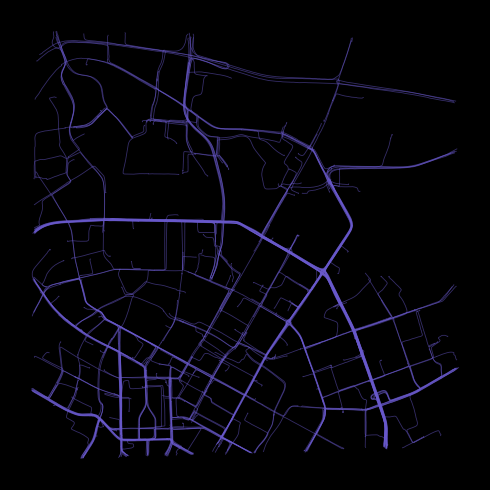

In [5]:
mean = np.array([30.68176148, 104.07740728])
std = np.array([0.01975033, 0.02220808])

import matplotlib.pyplot as plt

Gen_traj = []

plt.figure(figsize=(5, 5), facecolor='black')  
ax = plt.gca()

plt.axis('off')

# xlim = [104.02, 104.14] 
# ylim = [30.62, 30.74]   
# plt.xlim(xlim)
# plt.ylim(ylim)

for i in range(len(images)):
    traj=images[i]
    new_traj = traj.T * std + mean
    Gen_traj.append(new_traj)
    plt.plot(new_traj[:,1],new_traj[:,0],color='slateblue', linewidth=0.6, alpha=0.5)
plt.tight_layout()

plt.savefig('tmp0.pdf')
plt.show()